<h1>Project 1</h1>

By Rishi Shah (rs6wt), Tarun Donipati (td3qn), and Yash Kolli (ysk6dw)

<h2>Introduction</h2>

In this project, our team has worked to analyze raw data and create a recommendations engine which maximizes utility for customer of a given product. In this first step, we are reading in the data and importing packages necessary for our program.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import sklearn
import statistics
import time, sys
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
df = pd.read_csv ("features1.csv")

<h2>Data Cleaning</h2>

This data (<em>features1.csv</em>) is the cleaned version of the raw data (<em>scanner.csv</em>).
Below are the steps we took to get from the raw data to the cleaned data.

First, we read in <em>scanner_data.csv</em> into the data variable and display the first five rows of the data along with the number of unique customer IDs and number of SKUs

In [2]:
data = pd.read_csv ("scanner_data.csv")
data.head()
print(  "Number of Customer_ID",    len(pd.unique(data['Customer_ID']))  )
print(  "Number of SKU  ",    len(pd.unique(data['SKU']))  )

Number of Customer_ID 22625
Number of SKU   5242


Next, we create a range of 52 weeks, encompassing each week in 2016, and label each transaction within the week they occur.

In [3]:
data['Date'] = pd.to_datetime(data['Date'], format = '%d/%m/%Y')
data = data.drop(columns=['Unnamed: 0'])
data['Week'] = data['Date'].dt.isocalendar().week
data['Week'] = data['Week'].replace(53, 0)
data['Bought'] = [1]*len(data)

In [4]:
def toDate(week):
    d = "2016-W" + str(week)
    r = datetime.strptime(d + '-1', '%G-W%V-%u')
    r = pd.to_datetime(r, format = '%d/%m/%Y')
    return r

Here, we create the proxy variable <strong><em>no_show</em></strong>. The purpose of <strong><em>no_show</em></strong> is to portray the users decision to buy or not buy. This is important because the buy decision signals utility while a decision not to buy signals a lack of utility.

The way we add this to our dataframe is to add a row per each customer for every week that a customer doesn't buy a product. The product name is labeled as No_Show and all the values within that row are set to 0, as no transaction is made.

In [5]:
# allCustomers = data['Customer_ID'].unique()
# weeks = range(0,53)
# for c in range(18552,len(allCustomers)):
#     custData = data[data['Customer_ID'] == allCustomers[c]]
#     week = list(custData['Week'].unique())
#     noShow = list(set(weeks) - set(week))
#     for w in noShow:
#         item = pd.DataFrame([[allCustomers[c], "NOSHOW", w, 0, 0, 1, -1, "NS", toDate(w)]], 
#                             columns = ["Customer_ID","SKU","Week","Sales_Amount","Quantity","Bought", "Transaction_ID", "SKU_Category", "Date"])
#         data = pd.concat([data, item], ignore_index=True)

As we make progress, we save the new dataframes as csv files as this allows us

In [6]:
# data.to_csv('transactions.csv', index = False)

<h2>Feature Engineering</h2>

To train our model to consider the best utility calculations, we include many features which we derived from our existing cleaned data. Each feature calculates a customer-based metric that helps increase the accuracy of a recommendation to the customer. When training our model, these features are compiled into a feature vector, which then help to calculate utility for our model.

Let's explore these features!

Our first feature is Week. This calculates the week in which the transaction was made. It is calculated by dividing dates into a range of 52 weeks and classifying each transaction into the week it happened.

In [7]:
# allCustomers = data['Customer_ID'].unique()
# weeks = range(0,53)
# for c in range(18552,len(allCustomers)):
#     custData = data[data['Customer_ID'] == allCustomers[c]]
#     week = list(custData['Week'].unique())
#     noShow = list(set(weeks) - set(week))

# data

The second feature is repurchase rate. This measures how often the customer repurchases a particular product. The intuition behind this feature is that a customer who has more utility for a certain product will buy it more often. As such, the repurchase rate should be high for a high-utility customer. This is calculated by dividing the number of specific products within a customer over the number of customers.

In [8]:
# repurchaseRate = []

# for c in range(len(data['Customer_ID'])):
#     #calculate customer repurchase rate
#     custData = data.loc[data['Customer_ID'] == data['Customer_ID'][c]]
#     specificProds = custData['SKU'].unique()
#     repurchaseRate.append(len(specificProds)/len(custData))
    
# data['repurchase_rate'] = repurchaseRate

# data

Products per Sale measures the average number of products in a particular transaction. The higher the number, the more utility the customer has for the store. This is calculated by taking the quantity divided by the number of specific sales.

In [9]:
# prodsPerSale = []

# for c in range(len(data['Customer_ID'])):
#     #calculate products per sale
#     specificSales = custData['Transaction_ID'].unique()
#     quant = np.sum(np.array(custData['Quantity']))
#     avgQuant = quant/len(specificSales)
#     prodsPerSale.append(avgQuant)

# data['products_per_sale'] = prodsPerSale


Total transactions records the number of transactions the customer makes in our data timeframe. The higher the number, the more utility the customer has for the store. It is calculated by taking the tally of unique transaction IDs within a customer's data.

In [10]:
# totalTrans = []

# for c in range(len(data['Customer_ID'])):
#      #calculate total transactions
#     numTrans = len(custData)
#     totalTrans.append(numTrans)

# data['total_transactions'] = totalTrans

Total Spent finds the total amount the customer spends in our data timeframe. The higher the number, the more utility the customer has for the store. It is calculated by taking the sum of all sales amounts within a customer's data.

In [11]:
# totalSpent = []

# for c in range(len(data['Customer_ID'])):
#     #calculate total amount spent by customer
#     spent = np.sum(custData['Sales_Amount'])
#     totalSpent.append(spent)

# data['total_spent'] = totalSpent

Proportion of categories measures how many of the customer's purchased SKUs fall into a SKU Category. The higher the number, the more utility the customer has for that particular category. It is calculated by taking the number of unique SKU Categories in customer data and dividing it by total number of SKU Categories.

In [12]:
# proportionCategories = []

# for c in range(len(data['Customer_ID'])):
#     #calculate proportion categories
#     specificCategories = custData['SKU_Category'].unique()
#     prop = len(specificCategories)/187
#     proportionCategories.append(prop)

# data['proportion_categories'] = proportionCategories

Average spent per transaction measures how much money is spent on average in one transaction. The greater the amount, the greater the utility for the store. This is calculated by taking the total amount spent in each transaction and finding the mean.

In [13]:
# ratios = []
# for customer in data['Customer_ID']:
#     temp_df = data.loc[data['Customer_ID'] == customer]
#     total_sum = 0
#     for i in range(0, len(temp_df)):
#         total_sum = total_sum + int(data.iloc[i]['Quantity']) * int(data.iloc[i]['Sales_Amount'])
#     ratio = total_sum / len(temp_df['Transaction_ID'].unique())
#     ratios.append(ratio)
# data['avg_spent_transaction'] = ratios

Average quantity bought per transaction measures the average number of products an individual customer bought in a single transaction. The higher the number, the more utility the customer has for the store. This is calculated by summing the total number of products bought in each transaction and dividing by the total number of transactions.

In [14]:
# # Average Quantity of Item Bought
# avg_quant_per_item = []

# for customer in data['Customer_ID']:
#     temp_df = data.loc[data['Customer_ID'] == customer]
#     quant = np.sum(temp_df['Quantity'])
#     totaltrans = len(temp_df)
#     avg_quant = quant/totaltrans
#     avg_quant_per_item.append(avg_quant)

# data['avg_quant_item'] = avg_quant_per_item

SKU Category standard deviation finds the standard deviation of SKUs bought in an individual SKU Category. In a sense, we are measuring the variation in the customer data. The higher the number, the greater the variety of product bought, and the more utility a customer has for the store.

In [15]:
# # SKU Category Standard Deviation
# import statistics

# standard_deviation = []

# for c in range(len(data['Customer_ID'])):
#     sku_list = data.loc[data['Customer_ID'] == data['Customer_ID'][c]]['SKU_Category'].unique()
#     stdev_list = []
#     for sku in sku_list:
#         temp_df = data.loc[data['Customer_ID'] == data['Customer_ID'][c]][data['SKU_Category'] == sku]
#         stdev_list.append(np.sum(temp_df['Quantity']))
#     stdev = statistics.pstdev(stdev_list)
#     standard_deviation.append(stdev)

# data['sku_category_sd'] = standard_deviation

Transaction rate Before/After Trump finds whether transactions for a customer increased after Trump's election or before Trump's election. Essentially, we are trying to find how the political environment affects buying patterns and whether an election can increase user demand for products. This is calculated by a categorical variable marked 0 if transactions increased after election and 1 if transactions decreased or stayed the same after the election.

In [16]:
# beforeTrump = []
# df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')
# TrumpElection = datetime(2016, 11, 8)
# for c in range(len(data['Customer_ID'])):
#     custData = df.loc[df['Customer_ID'] == data['Customer_ID'][c]]
#     totalTrans = len(custData['Transaction_ID'].unique())
#     preTrump = df.loc[df['Date'] < TrumpElection]
#     transactionsPerDayBeforeTrump = len(preTrump['Transaction_ID'].unique())/312
#     transactionsPerDayAfterTrump = (totalTrans - len(preTrump['Transaction_ID'].unique()))/53
#     if transactionsPerDayAfterTrump > transactionsPerDayBeforeTrump:
#         beforeTrump.append(0)
#     else:
#         beforeTrump.append(1)
# data['transaction_rate_trump'] = beforeTrump

These features are then added as columns next to our transactions.csv dataframe and saved as the <em>features1.csv</em> file

<h2>Regression and Training</h2>

After obtaining our cleaned dataset, we must then train our model to find the utility and probability of a customer's utility for a product given our feature vector. Then, we can use a multinomial logistic regression to classify and recommend products based on a given feature vector.

In our first step, we must outline the explanatory and response variables for our regression. Our explanatory variables are our features. These features consist of:
<ul>
    <li>Week</li>
    <li>Repurchase Rate</li>
    <li>Products per Sale</li>
    <li>Total Transactions</li>
    <li>Total Spent</li>
    <li>Proportion Categories</li>
    <li>Average Spent per Transaction</li>
    <li>Average Quantity Bought per Transaction</li>
    <li>SKU Category</li>
    <li>Transaction Rate Before/After Trump</li>
    <li>Price</li>
</ul>

Our response variable is the SKU_Map, as we are trying to find the product to recommend based on our feature vector.

Because our data consists of more than a million rows, training on the whole data would take up tons of computing resources and runtime is calculated to be more than a week. Instead, our team decided to train our model on 1% of the cleaned data, sampling 13000 rows. We then split this data into 80% training data and 20% test data.

In [17]:
df = df.sample(n=13000, random_state=5)
y = df['SKU_Map']
features = ['Week', 'repurchase_rate','products_per_sale', 'total_transactions','total_spent', 'proportion_categories', 'avg_spent_transaction', 'avg_quant_item', 'sku_category_sd', 'transaction_rate_trump', 'Price']
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Then, we outline our logistic regression model to be a multinomial regressor using the Stochastic Average Gradient solver. Let's explore these terms in a little more. A multinomial logistic regressor is an extension of the binary classifier logistic regressor where the regression can classify to more than two categories. In this case, we are using the multinomial regression to classify our feature vector to the many SKU_Map categories.

A solver for logistic regression is the way in which a logistic regression converges and optimizes the parameters through gradient descent. Gradient descent finds the optimal set of parameters by minimizing the convex loss function. This particular solver <strong><em>saga</em></strong> (Stochastic Average Gradient) allows for fast optimization of larger data sets and allows for L1 Regularization (<em>Lasso regression</em>) which specifies the absolute value of magnitute of coefficient as the penalty for overcomplexity.  

In [18]:
# model=sklearn.linear_model.LogisticRegression(multi_class='multinomial', penalty='none', solver='sag', max_iter=100)
# model.fit(X_train, y_train)

Due to the massive dataset that included the no show weeks (about 1.3 million observations), the regression would have taken days to run. However, by excluding these extra rows, we are able to reduce the size of the dataset to (about 130,000 observations). We were able to train this model with a 70 - 30 train test split in nearly 85 minutes

Why might it have taken so long to train?

There is some correlation between features, as shown below, which slows down convergence.


In [19]:
final_df = pd.read_csv('features1.csv')
final_df = final_df.fillna(0)
final_df

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,Week,repurchase_rate,products_per_sale,total_transactions,total_spent,proportion_categories,avg_spent_transaction,avg_quant_item,sku_category_sd,transaction_rate_trump,SKU_Map,Price
0,2016-01-02,2547,1,X52,0EM7L,1.0,3.13,0,0.875,3.142857,16,121.36,0.058824,12.714286,1.375,1.595448,1,0,3.13
1,2016-01-04,2547,332,Q4N,MM3E0,1.0,12.69,1,0.875,3.142857,16,121.36,0.058824,12.714286,1.375,1.595448,1,1,12.69
2,2016-01-25,2547,3743,X52,885U7,1.0,4.95,4,0.875,3.142857,16,121.36,0.058824,12.714286,1.375,1.595448,1,2,4.95
3,2016-01-25,2547,3743,29A,A59HR,3.0,6.24,4,0.875,3.142857,16,121.36,0.058824,12.714286,1.375,1.595448,1,3,2.08
4,2016-02-22,2547,8477,L9F,7W8WS,1.0,11.75,8,0.875,3.142857,16,121.36,0.058824,12.714286,1.375,1.595448,1,4,11.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131701,2016-07-04,5751,32874,LSD,NSGRM,1.0,11.02,27,1.000,3.000000,3,59.59,0.016043,14.000000,1.000,0.000000,1,1780,11.02
131702,2016-07-04,5751,32874,0H2,9Q5PZ,1.0,7.85,27,1.000,3.000000,3,59.59,0.016043,14.000000,1.000,0.000000,1,2808,7.85
131703,2016-07-04,5751,32874,D6J,52BYA,1.0,40.72,27,1.000,3.000000,3,59.59,0.016043,14.000000,1.000,0.000000,1,1713,40.72
131704,2016-07-04,10765,32881,Z4O,6IISH,1.0,1.19,27,1.000,1.000000,1,1.19,0.005348,3.000000,1.000,0.000000,1,1570,1.19


In [20]:
columns = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
X = final_df.iloc[:, columns]

In [21]:
X.corr()

,Week,repurchase_rate,products_per_sale,total_transactions,total_spent,proportion_categories,avg_spent_transaction,avg_quant_item,sku_category_sd,transaction_rate_trump,Price
Week,1.000000,-0.128606,-0.007314,0.103458,0.102741,0.101707,-0.000694,0.004120,0.050178,NaN,0.013371
repurchase_rate,-0.128606,1.000000,-0.134717,-0.601612,-0.591943,-0.490777,-0.361208,-0.067219,-0.346760,NaN,-0.023604
products_per_sale,-0.007314,-0.134717,1.000000,0.124852,0.180901,0.131686,0.487218,0.755438,0.563676,NaN,0.021133
total_transactions,0.103458,-0.601612,0.124852,1.000000,0.855015,0.899923,0.392578,0.045644,0.359480,NaN,0.011757
total_spent,0.102741,-0.591943,0.180901,0.855015,1.000000,0.769255,0.426130,0.077755,0.380050,NaN,0.114363
proportion_categories,0.101707,-0.490777,0.131686,0.899923,0.769255,1.000000,0.406568,0.041340,0.278992,NaN,0.021260
avg_spent_transaction,-0.000694,-0.361208,0.487218,0.392578,0.426130,0.406568,1.000000,0.062428,0.195262,NaN,0.033241
avg_quant_item,0.004120,-0.067219,0.755438,0.045644,0.077755,0.041340,0.062428,1.000000,0.538480,NaN,0.003807
sku_category_sd,0.050178,-0.346760,0.563676,0.359480,0.380050,0.278992,0.195262,0.538480,1.000000,NaN,0.003620
transaction_rate_trump,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As you can see in the heatmap below, there is high correlation between total transactions and total spent, proportion categories and total spent, SKU category and products per sale, products per sale and average quantity per transaction, and SKU Category and average quantity per transaction. 

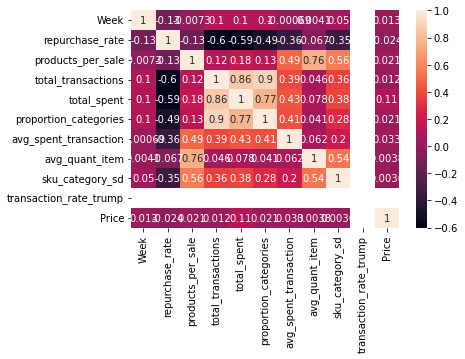

In [22]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(X.corr(), annot=True)
plt.show()

# What Worked:

### Question 4

In [23]:
columns = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
X = final_df.iloc[:, columns].values.tolist()

In [24]:
Y = final_df.iloc[:, -2]

In [25]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size = 0.3, random_state=42)

In [26]:
training_skus = set(y_train.unique())
all_skus = set(Y.unique())

In [27]:
missing_skus = all_skus.difference(training_skus)

In [28]:
add_to_X = []
add_to_Y = []

for num in missing_skus:
    for l in final_df.loc[final_df['SKU_Map'] == num].iloc[:, columns].values.tolist():
        add_to_X.append(l)
        add_to_Y.append(num)  

In [29]:
X_train.extend(add_to_X)

In [30]:
y_train = list(y_train)
y_train += add_to_Y

In [31]:
model=sklearn.linear_model.LogisticRegression(multi_class='multinomial', penalty = 'none', solver='saga', max_iter=100)
model

LogisticRegression(multi_class='multinomial', penalty='none', solver='saga')

In [32]:
#model.fit(X_train, y_train)

In [33]:
import random
import pickle
filename = 'finalized_model.sav'
model = pickle.load(open(filename, 'rb'))
model

LogisticRegression(multi_class='multinomial', penalty='none', solver='saga')

In [34]:
columns = [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
sampling_df = final_df.iloc[:, columns]

Beta values for first example SKU (mapped to integer classes):

In [35]:
model.coef_[0]

array([ 8.13745101e-04,  1.47662664e-05, -2.39578119e-04,  1.34257865e-03,
        4.63629584e-03,  3.51137803e-06, -3.60251265e-04, -3.72222617e-05,
       -2.44139942e-04,  2.97489853e-05, -1.17162354e-03])

Intercept (bias) of first SKU: 

In [36]:
model.intercept_[0]

2.9748985269531415e-05

We can now calculate utility of item j for customer i with a simple dot product

Let customer i = 2547 and j is the first SKU (mapped to 0)

In [37]:
np.dot(model.coef_[0], np.array(sampling_df.loc[sampling_df['Customer_ID'] == 2547].iloc[0].tolist()[1:])) + model.intercept_[0]

0.5747735746746226

Let's move on to interpretting and finding value of these results and running simulations

# Project Part 2

### Question 1

Epsilon-Greedy Multi-Arm Bandit Algorithm:

In [38]:
def decide(customer_id):
    
    products = [None] * len(model.coef_)
    products[0] = 0
    data = [None] * len(model.coef_)
    data[0] = 0
    eps = 0.2
    
    for i in range(1, len(model.coef_)): 
        p = np.random.random()
        rand = random.choice(list(range(0, len(model.coef_))))

        if p < eps:
            utility = np.dot(model.coef_[rand], np.array(sampling_df.loc[sampling_df['Customer_ID'] == customer_id].iloc[0].tolist()[1:])) + model.intercept_[rand]
        else:
            utility = data[np.argmax(data[0:i])]
        
        data[i] = max(utility, data[i - 1]) 
        
        if data[i - 1] >= utility:
            products[i] = products[i - 1]
        else:
            products[i] = rand
            
    max_utility = data[-1]
    sku = final_df.loc[final_df['SKU_Map'] == products[-1]].iloc[0].tolist()[4]
        
    return [sku, data[-1]]

Test Decision Algorithm by Inputting Any Customer_ID (ex. 2547)

In [39]:
decide(2547)

['TL4WZ', 1.5525786311683019]

Rewards Difference function calculates the difference between the maximum utility and average utility of a customer

In [40]:
def rewards_difference(customer_id):
    products = [None] * len(model.coef_)
    products[0] = 0
    
    data = [None] * len(model.coef_)
    data[0] = 0

    eps = 0.2
    
    for i in range(1, 100): 
        p = np.random.random()
        rand = random.choice(list(range(0, len(model.coef_))))

        if p < eps:
            utility = np.dot(model.coef_[rand], np.array(sampling_df.loc[sampling_df['Customer_ID'] == customer_id].iloc[0].tolist()[1:])) + model.intercept_[rand]
        
        else:
            utility = data[np.argmax(data[0:i])]
        
        data[i] = max(utility, data[i - 1])
        
        if data[i - 1] >= utility:
            products[i] = products[i -1]
        
        else:
            products[i] = rand
    
    max_utility = decide(customer_id)[1]
    utility_100_iter = data[99]
    delta = max_utility - utility_100_iter
        
    return delta

In [41]:
rewards_difference(2547)

0.210800584273531

### Question 2

Function that tracks iteration progress of a loop

In [42]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

Simulation of average of 1000 reward differences for randomly selected cutomers

In [43]:
def simulation():
    
    get_rand_customers = random.sample(list(final_df['Customer_ID'].unique()), 1000)
    sum = 0
    
    for i in range(len(get_rand_customers)):
        sum += rewards_difference(get_rand_customers[i])
        update_progress(i / 999)
        
    return sum / 1000

In [44]:
simulation()

Progress: [####################] 100.0%


1.3319112337643444

For 1000 customers, the average of the difference between the maximum utility of a customer and mean utility they have for 100 random products is about 1.22.

The reason there is such a large difference is because customers have unique features which favor some products over others. The products with the highest utility are likely to be be very different from the average utility of many products for a given customer. We know economically, by preference and choice that consumers value more goods with liitle utility and few goods with high utility. This intuitively explains why the simulation output is significant.

<h2>Failures and Learning</h2>

While we were doing this project, we tried many ways to solve this problem. The way above works. However, we also wanted to show you our failed attempts and why they failed.

Below, we have our first failed data organization approach. The reason this failed was because we were taking the number of weeks each SKU was bought as an array value of per customer per SKU. This made it harder on our analysis because we weren't able to derive the no_show variable easily from this and regress it into our model. Instead, we were trying to calculate the probability that a customer has utility for a SKU by determining whether or not they bought the product, rather than a regression of the features developed.

In [45]:
df_fail1 = pd.read_csv("data.csv")
df_fail1.head()

,Customer_ID,SKU,Weeks,Probability,Average Repurchase Time (Customer),Average Repurchase Time (SKU),Repurchase Slope,Returning Customer,Price,Quantity
0,2547,0EM7L,[0],1,363.0,0,363.0,0.0,3.13,1.0
1,2547,MM3E0,[1],1,363.0,0,363.0,0.0,12.69,1.0
2,2547,885U7,"[4, 12]",1,2.0,0,2.0,1.0,4.95,1.0
3,2547,A59HR,[4],1,363.0,0,363.0,0.0,2.08,3.0
4,2547,7W8WS,[8],1,363.0,0,363.0,0.0,11.75,1.0


The second failure was when we organized our customer purchases as a tally of purchases in each SKU Category and added that as a column. We then calculated no show as the total number of dates minus the number of dates a product was bought. This failed because there was no clear way to get from our purchase tallies to a logistic regression that predicted the probability of utility.

In [46]:
df_fail2 = pd.read_csv("newdata1.csv")
df_fail2

,Customer_ID,X52,2ML,0H2,JPI,XG4,FEW,N5F,H8O,N8U,...,no_show,repurchase_rate,products_per_sale,total_transactions,total_spent,proportion_categories,avg_spent_transaction,avg_quant_item,sku_category_sd,transaction_rate_trump
0,2547,4,0,0,0,0,0,1,0,2,...,347.0,0.875000,3.142857,16,121.36,0.058824,12.714286,1.375000,1.595448,1
1,822,0,1,0,0,0,0,0,0,0,...,358.0,1.000000,1.666667,5,20.40,0.021390,8.333333,1.000000,0.433013,1
2,3686,3,0,4,0,0,1,0,0,3,...,313.0,0.860000,4.200000,50,405.44,0.133690,22.800000,1.260000,1.652150,1
3,3719,0,0,2,0,1,0,0,0,3,...,316.0,0.765957,7.000000,47,420.72,0.117647,33.400000,1.489362,2.102733,1
4,9200,0,0,1,0,0,0,0,0,0,...,361.0,1.000000,1.000000,2,18.01,0.010695,4.000000,1.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22620,14811,0,0,0,0,0,0,0,0,0,...,362.0,1.000000,1.000000,1,26.54,0.005348,3.000000,1.000000,0.000000,1
22621,3232,0,0,0,0,0,0,0,0,1,...,361.0,1.000000,2.000000,2,12.89,0.010695,8.000000,1.000000,0.000000,1
22622,5751,0,0,1,0,0,0,0,0,0,...,360.0,1.000000,3.000000,3,59.59,0.016043,14.000000,1.000000,0.000000,1
22623,10765,0,0,0,0,0,0,0,0,0,...,362.0,1.000000,1.000000,1,1.19,0.005348,3.000000,1.000000,0.000000,1


Our failures in this project resulted from a lack of understanding regarding how to organize data for a logistic regression. All these are valid solutions when trying to organize data to get insight into customer purchase patterns. However, for logistic regression, our final solution (inspired by our previous failures) finds the most effective and simple way to analyze our data for the logistic regression.

In fact, our final solution was a combination of our two previous solutions. In our final solution, we added a row for every week that a customer didn't show up. This is similar to how we calculated the number of weeks a customer showed up in our first solution.

In our second solution, we were trying to regress our model against one SKU category. Essentially, the goal was to classify the optimal SKU category given a feature vector. In our final solution, we classified SKUs under SKU_map and used our feature vectors to find the optimal SKU classification for the customer.

As such, without our failures, we wouldn't have been able to create our final solution. The effort and learning we put into this project are the key to our final solution's effectiveness.

Spending nearly 200 hours on this project, talking with professors, and consulting with TAs was quite a difficult experience, but in the end a very rewarding journey in which we learned a tremendoes amount.